# Feature Engineering & Model

Import the necessary packages:

In [22]:
import re
import pickle
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scaling
from sklearn.preprocessing import StandardScaler

# Train-test split and Grid Search
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import plot_partial_dependence

# Feature Engine
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
                              f1_score, classification_report, precision_recall_curve,
                              confusion_matrix )

# Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Utils
from utils import *

Read the data, and create a copy of it:

In [9]:
df = pd.read_csv('data/train_data.csv')
df_ = df.copy(deep = True)

df_ = df_.replace('?', np.nan)

# df_['total_visits'] = df_['number_inpatient'] + df_['number_outpatient'] + df_['number_emergency']

Train-test split:

In [10]:
target = 'readmitted'

X = df_.drop(columns = target)
y = df_[target].apply(lambda x: False if x == 'No' else True)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y)

In [11]:
# df_test = pd.concat([X_test, y_test], axis = 1)

# df_test.to_csv('data/test_data.csv')

Drop unknown genders, and vaccination statuses:

In [12]:
print(X_train.shape[0])

X_train = X_train[X_train['gender'] != 'Unknown/Invalid']
X_train = X_train[X_train['complete_vaccination_status'] != 'None']
# X_train = X_train[X_train['discharge_disposition_code'] != 11.0 ]

print(X_train.shape[0])

y_train = y_train[y_train.index.isin(X_train.index)]

65129
64875


## Feature Engineering

We need to take the following steps in the feature engineering pipeline:

1. Drop the 'admission_id', 'patient_id', 'weight' columns;
2. Make corrections to the 'race' column;
3. Drop the 'Unknown' gender in the 'gender' column;

In [13]:
features_to_drop = ['admission_id',
                    'patient_id',
                    'weight',
                    'medical_specialty',
                    'payer_code',
                    'blood_type',
                    'has_prosthesis',
                    #'diag_1',
                    #'diag_2',
                    #'diag_3',
                    'race',
                    'age',
                    'gender',
                   ]

categorical_features = [ #'race',
                         #'gender',
                        'admission_type_code',
                        'discharge_disposition_code',
                        'admission_source_code',
                        'complete_vaccination_status', # Need to think about this one
                        'blood_transfusion',
                        'max_glu_serum',
                        'A1Cresult',
                        'diuretics',
                        'insulin',
                        'change',
                        'diabetesMed',
                        'diag_1',
                        'diag_2',
                        'diag_3',
                       ]

categorical_features_ohe_2mf = [# 'gender',
                               'complete_vaccination_status']

numerical_features_imputation = ['num_medications',
                                 'num_lab_procedures',
                                 'num_procedures',
                                 'number_diagnoses',
                                 'time_in_hospital',
                                 'number_outpatient',
                                 'number_emergency',
                                 'number_inpatient',
                                 'number_diagnoses',
                                ]

numerical_features = [# 'age',
                      # 'time_in_hospital',
                      # 'num_lab_procedures',
                      # 'num_procedures',
                      # 'num_medications',
                      # 'number_outpatient',
                      # 'number_emergency',
                      # 'number_inpatient',
                      # 'number_diagnoses',
                      'hemoglobin_level',
                     ]

Pipeline:

In [14]:
pipe = Pipeline([    
    # Remove unwanted columns
    ('drop', DropFeatures(features_to_drop = features_to_drop)),
    
    # Correct type of columns
    ('object', CastString()),
    
    # Correct the race column
    # ('race', CorrectRace()),
    
    # Map the age column
    # ('age', ConvertAge()),
    
    # Correct the admission type column
    ('admission_type', CorrectAdmissionTypeCode()),
    
    # Correct the discharge disposition code column
    ('discharge_code', CorrectDischargeDispositionCode()),
    
    # Correct the admission source code column
    ('admission_code', CorrectAdmissionSourceCode()),
    
    # Correct the max glu serum column
    ('max_glu_serum', CorrectMaxGluSerum()),
     
    # Correct the A1CResult column
    ('a1cresult', CorrectA1CResult()),
    
    # Correct the diag_1, diag_2 and diag_3 columns
    ('diag_x', ConvertDiag()),
    
    # Impute the categorical features with the mode
    ('categorical_imputer', CategoricalImputer(imputation_method = 'frequent',
                                                variables = categorical_features)),
    
    # Impute the numerical features with the median
    ('numerical_imputer_median', MeanMedianImputer(imputation_method = 'median',
                                            variables = numerical_features)),
     
    ('numerical_imputer_0', ArbitraryNumberImputer(arbitrary_number = 0,
                                                 variables = numerical_features_imputation)),
    
    # Rare label encoding
    ('rare', RareLabelEncoder(tol = 0.01, 
                              n_categories = 2,
                              variables = categorical_features)),
    
    # One-hot encoding
    ('ohe', OneHotEncoder(variables = [f for f in categorical_features if f not in categorical_features_ohe_2mf])),
    
    # One-hot encoding of top 2
    ('ohe_diag', OneHotEncoder(top_categories = 2,
                              variables = categorical_features_ohe_2mf)),
    
    # Model
    # ('clf', RandomForestClassifier(# n_estimators = 1000,
    #                                # max_depth = 10,
    #                                # class_weight = 'balanced',
    #                                random_state = 42,
    #                                n_jobs = -1))

])

In [15]:
X_train_tf = pipe.fit_transform(X_train)
X_train_tf.head()

# X_train_tf = pipe.fit_transform(X_train)
# 
# sm = SMOTE(random_state = 42)
# train_input_new, train_output_new = sm.fit_sample(X_train_tf, y_train)

# pipe.fit(X_train, y_train)

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/feature_engine/encoding/rare_label.py:164: UserWarning: The number of unique categories for variable complete_vaccination_status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/feature_engine/encoding/rare_label.py:164: UserWarning: The number of unique categories for variable blood_transfusion is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/feature_engine/encoding/rare_label.py:164: UserWarning: The number of unique categories for variable diuretics is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/feature_eng

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,hemoglobin_level,admission_type_code_1.0,...,diag_3_780-799,diag_3_320-389,diag_3_800-999,diag_3_140-239,diag_3_280-289,diag_3_Unknown,diag_3_0-139,diag_3_Rare,complete_vaccination_status_Complete,complete_vaccination_status_Incomplete
6400,6,82.0,0,17.0,0,0,0,9,15.4,1,...,0,0,0,0,0,0,0,0,1,0
4000,9,53.0,5,41.0,0,0,2,9,13.8,1,...,0,0,0,0,0,0,0,0,1,0
39818,1,41.0,2,13.0,0,0,0,9,13.6,0,...,0,0,0,0,0,0,0,0,1,0
23698,3,70.0,1,0.0,0,0,0,8,14.1,1,...,0,0,0,0,0,0,0,0,1,0
71883,2,20.0,0,13.0,0,0,0,8,13.2,1,...,0,0,0,0,0,0,0,0,1,0


In [16]:
clf = RandomForestClassifier(n_estimators = 1000, 
                             max_depth = 10,
                             class_weight = 'balanced',
                             criterion = 'gini',
                             random_state = 42)

clf.fit(X_train_tf, y_train)

# clf = LogisticRegression(penalty = 'l1',
#                          C = 1e-1,
#                          # class_weight = 'balanced',
#                          solver = 'liblinear', 
#                          random_state = 42)

# clf.fit(train_input_new, train_output_new)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=1000,
                       random_state=42)

In [17]:
X_test_tf = pipe.transform(X_test)

In [18]:
y_pred_test = clf.predict(X_test_tf)
y_pred_train = clf.predict(X_train_tf)

# y_pred_test = pipe.predict(X_test)
# y_pred_train = pipe.predict(X_train)

print(classification_report(y_test, y_pred_test))

print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))
print('F1-Score:', f1_score(y_train, y_pred_train))
print('\n')
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('Recall:', recall_score(y_test, y_pred_test))
print('F1-Score:', f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.92      0.69      0.79     14469
        True       0.18      0.55      0.27      1814

    accuracy                           0.67     16283
   macro avg       0.55      0.62      0.53     16283
weighted avg       0.84      0.67      0.73     16283

Accuracy: 0.6923776493256262
Precision: 0.2118275674696613
Recall: 0.6471157836491908
F1-Score: 0.3191757923105789


Accuracy: 0.6700853651047104
Precision: 0.17980561555075594
Recall: 0.5507166482910695
F1-Score: 0.27109905020352787


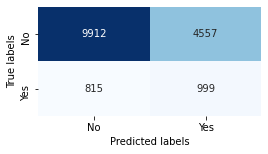

In [19]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize = (4, 2))

ax = plt.subplot()
sns.heatmap(cm, annot = True, 
            fmt = 'g', 
            cmap = 'Blues',
            ax = ax, cbar = False ); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);

In [20]:
y_pred_proba_test = clf.predict_proba(X_test_tf)[:, 1]

In [24]:
pickle.dump(y_pred_proba_test, open("data/y_pred_predictions.pickle", "wb"))
pickle.dump(y_pred_test, open("data/y_pred_test.pickle", "wb"))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.662


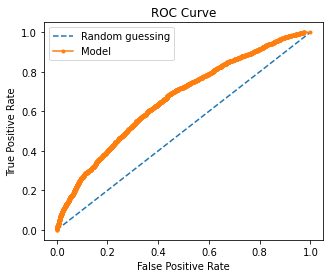

In [13]:
ns_probs = [0 for _ in range(X_test.shape[0])]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred_proba_test)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize = (5, 4))

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'Random guessing')
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the title
plt.title('ROC Curve')

# show the plot
plt.show()

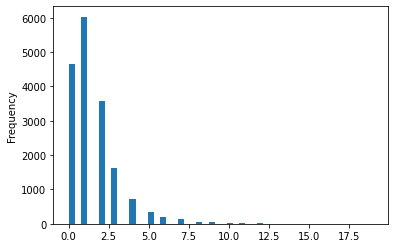

In [24]:
X_train_tf[(y_train != y_pred_train) & (y_train == False)]['number_inpatient'].plot(kind = 'hist', bins = 50)

plt.show()

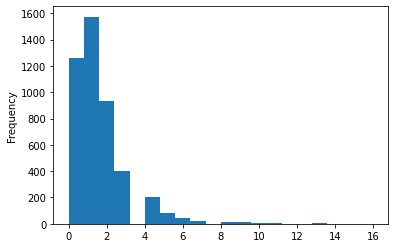

In [28]:
X_test_tf[(y_test != y_pred_test) & (y_test == False)]['number_inpatient'].plot(kind = 'hist', bins = 20)

plt.show()

In [30]:
X_test_tf[(y_test != y_pred_test) & (y_test == False)]['discharge_disposition_code_1.0'].value_counts(normalize = True)

0    0.541365
1    0.458635
Name: discharge_disposition_code_1.0, dtype: float64

## Feature importances

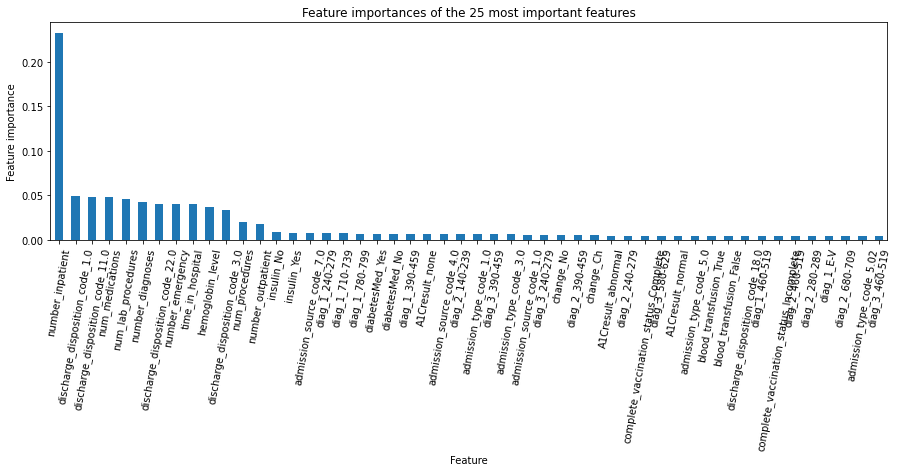

In [15]:
fi = pd.Series(clf.feature_importances_, index = X_train_tf.columns).sort_values(ascending = False)[:50]

plt.figure(figsize = (15,4))
fi.plot.bar()

plt.xticks(rotation = 80)

plt.xlabel('Feature')
plt.ylabel('Feature importance')

plt.title('Feature importances of the 25 most important features')

plt.show()

<Figure size 360x288 with 0 Axes>

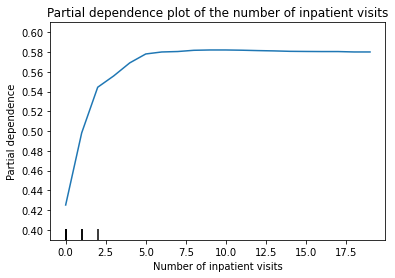

In [112]:
plt.figure(figsize = (5, 4))

plot_partial_dependence(clf, X_train_tf, features = [6])

plt.xlabel('Number of inpatient visits')
plt.ylabel('Partial dependence')

plt.title('Partial dependence plot of the number of inpatient visits')

plt.yticks(np.arange(0.4, 0.62, 0.02))
plt.ylim([0.39, 0.61])

plt.show()

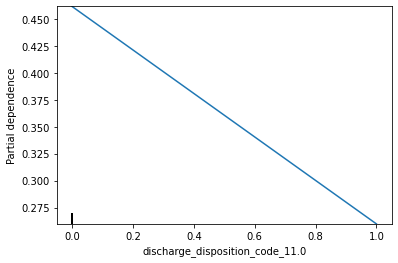

In [80]:
plot_partial_dependence(clf, X_train_tf, features = [14])

plt.show()

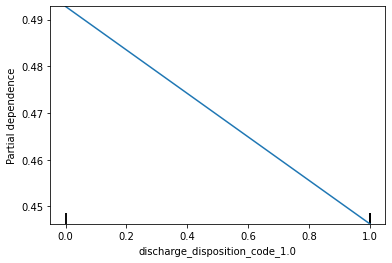

In [88]:
plot_partial_dependence(clf, X_train_tf, features = [13])

plt.show()

<Figure size 360x288 with 0 Axes>

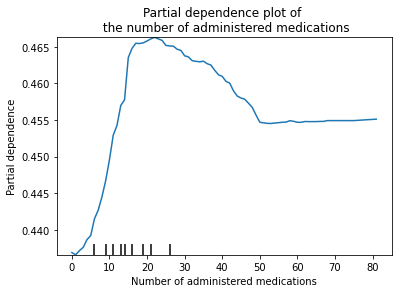

In [91]:
plt.figure(figsize = (5, 4))

plot_partial_dependence(clf, X_train_tf, features = [3])

plt.xlabel('Number of administered medications')
plt.ylabel('Partial dependence')

plt.title('Partial dependence plot of \n the number of administered medications')

# plt.yticks(np.arange(0.4, 0.62, 0.02))
# plt.ylim([0.39, 0.61])

plt.show()

In [ ]:
plt.gcf()

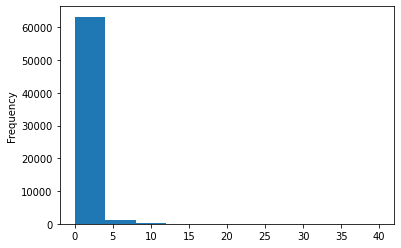

In [80]:
X_train_tf['number_outpatient'].plot(kind = 'hist')

plt.show()

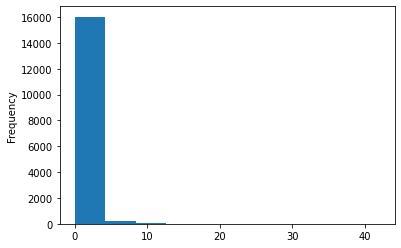

In [81]:
X_test_tf['number_diagnoses'].plot(kind = 'hist')

plt.show()

In [101]:
X_train_tf['change_Ch'].value_counts(normalize = True)*100

0    53.746435
1    46.253565
Name: change_Ch, dtype: float64

In [103]:
X_test_tf['change_Ch'].value_counts(normalize = True)*100

0    53.816864
1    46.183136
Name: change_Ch, dtype: float64

In [139]:
cols_to_analyse = ['admission_type_code_1.0', 'admission_type_code_5.0',
       'admission_type_code_3.0', 'admission_type_code_Rare',
       'discharge_disposition_code_1.0', 'discharge_disposition_code_11.0',
       'discharge_disposition_code_3.0', 'discharge_disposition_code_18.0',
       'discharge_disposition_code_22.0', 'discharge_disposition_code_Rare',
       'admission_source_code_7.0', 'admission_source_code_4.0',
       'admission_source_code_1.0', 'admission_source_code_Rare',
       'blood_transfusion_False', 'blood_transfusion_True',
       'max_glu_serum_none', 'max_glu_serum_normal', 'max_glu_serum_abnormal',
       'A1Cresult_abnormal', 'A1Cresult_none', 'A1Cresult_normal',
       'diuretics_No', 'diuretics_Yes', 'insulin_Yes', 'insulin_No',
       'change_Ch', 'change_No', 'diabetesMed_Yes', 'diabetesMed_No',
       'diag_1_390-459', 'diag_1_580-629', 'diag_1_780-799', 'diag_1_280-289',
       'diag_1_800-999', 'diag_1_520-579', 'diag_1_240-279', 'diag_1_E-V',
       'diag_1_460-519', 'diag_1_680-709', 'diag_1_710-739', 'diag_1_140-239',
       'diag_1_0-139', 'diag_1_290-319', 'diag_1_320-389', 'diag_1_Rare',
       'diag_2_460-519', 'diag_2_580-629', 'diag_2_390-459', 'diag_2_240-279',
       'diag_2_780-799', 'diag_2_520-579', 'diag_2_710-739', 'diag_2_680-709',
       'diag_2_800-999', 'diag_2_Unknown', 'diag_2_280-289', 'diag_2_290-319',
       'diag_2_0-139', 'diag_2_140-239', 'diag_2_E-V', 'diag_2_Rare',
       'diag_2_320-389', 'diag_3_240-279', 'diag_3_390-459', 'diag_3_460-519',
       'diag_3_580-629', 'diag_3_520-579', 'diag_3_710-739', 'diag_3_680-709',
       'diag_3_E-V', 'diag_3_290-319', 'diag_3_780-799', 'diag_3_320-389',
       'diag_3_800-999', 'diag_3_140-239', 'diag_3_280-289', 'diag_3_Unknown',
       'diag_3_0-139', 'diag_3_Rare', 'complete_vaccination_status_Complete',
       'complete_vaccination_status_Incomplete']

len_Xtrain = X_train.shape[0]
len_Xtest = X_test.shape[0]

for col in cols_to_analyse:
    train_set_counts = X_train_tf[y_train][col].sum()*100/len_Xtrain
    test_set_counts = X_test_tf[y_test][col].sum()*100/len_Xtest
    
    # if np.abs(train_set_counts - test_set_counts) > 
    
    print(col, np.round(train_set_counts,2), np.round(test_set_counts, 2))
    
    # print(col, abs(np.round(train_set_counts,2) - np.round(test_set_counts, 2)))

admission_type_code_1.0 8.04 7.85
admission_type_code_5.0 1.24 1.26
admission_type_code_3.0 1.86 2.03
admission_type_code_Rare 0.0 0.0
discharge_disposition_code_1.0 7.08 7.0
discharge_disposition_code_11.0 0.0 0.0
discharge_disposition_code_3.0 2.78 2.91
discharge_disposition_code_18.0 0.64 0.6
discharge_disposition_code_22.0 0.52 0.52
discharge_disposition_code_Rare 0.13 0.11
admission_source_code_7.0 6.63 6.45
admission_source_code_4.0 1.26 1.38
admission_source_code_1.0 3.21 3.26
admission_source_code_Rare 0.04 0.05
blood_transfusion_False 9.74 9.8
blood_transfusion_True 1.4 1.34
max_glu_serum_none 10.49 10.49
max_glu_serum_normal 0.29 0.29
max_glu_serum_abnormal 0.37 0.36
A1Cresult_abnormal 1.22 0.98
A1Cresult_none 9.48 9.67
A1Cresult_normal 0.45 0.49
diuretics_No 10.93 10.89
diuretics_Yes 0.21 0.25
insulin_Yes 6.57 6.7
insulin_No 4.58 4.44
change_Ch 5.46 5.42
change_No 5.68 5.72
diabetesMed_Yes 8.93 9.02
diabetesMed_No 2.22 2.12
diag_1_390-459 3.42 3.36
diag_1_580-629 0.54 0.55
d

In [138]:
num_cols_to_analyse = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'hemoglobin_level']

for col in num_cols_to_analyse:
    median_train = X_train_tf[y_train][col].median()
    mean_train = X_train_tf[y_train][col].mean()
    std_train = X_train_tf[y_train][col].std()
    
    median_test = X_test_tf[y_test][col].median()
    mean_test = X_test_tf[y_test][col].mean()
    std_test = X_test_tf[y_test][col].std()
    
    print(col)
    print(median_train, median_test)
    print(mean_train, mean_test)
    print(std_train, std_test)

time_in_hospital
4.0 4.0
4.752247890441279 4.762403528114664
3.0039467667740234 3.068674883092575
num_lab_procedures
45.0 44.0
43.53755706183428 42.72657111356119
19.931166320033256 19.906349676887935
num_procedures
1.0 1.0
1.278738414718495 1.3202866593164277
1.6379282072688301 1.654176790870153
num_medications
15.0 16.0
16.37487895974547 16.40848952590959
8.404284473548337 8.53106032189614
number_outpatient
0.0 0.0
0.423710056716005 0.4829106945975744
1.2750628583677739 1.362359458340573
number_emergency
0.0 0.0
0.3480426061695947 0.4178610804851158
1.4232983511206958 1.4800123173322588
number_inpatient
1.0 0.0
1.2240973855305022 1.2386990077177509
1.9358472201599113 2.076002582723326
number_diagnoses
9.0 9.0
7.7050767741043025 7.646637265711136
1.7679909152391993 1.7465582714423704
hemoglobin_level
14.1 14.1
14.191492599253007 14.187706725468578
1.0618938451196507 1.0610529430851965


## Grid Search for best Precision

In [12]:
%timeit

clf = RandomForestClassifier(random_state = 42)

param_grid = { 'n_estimators' : [250, 500, 1000],
               'max_depth' : [None, 5, 10, 15],
               'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(clf, 
                           param_grid,
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'precision',
                           verbose = 5)

grid_search.fit(X_train_tf, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15],
                         'n_estimators': [250, 500, 1000]},
             scoring='precision', verbose=5)

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.714 total time=  55.9s
[CV 3/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.857 total time= 4.2min
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=250;, score=0.000 total time=  27.1s
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.000 total time= 1.0min
[CV 2/5] END class_weight=None, max_depth=15, n_estimators=250;, score=1.000 total time=  41.6s
[CV 5/5] END class_weight=None, max_depth=15, n_estimators=250;, score=0.000 total time=  43.4s
[CV 4/5] END class_weight=None, max_depth=15, n_estimators=500;, score=1.000 total time= 1.3min
[CV 1/5] END class_weight=balanced, max_depth=None, n_estimators=250;, score=0.571 total time= 1.0min
[CV 4/5] END class_weight=balanced, max_depth=None, n_estimators=250;, score=1.000 total time=  58.1s
[CV 1/5] END class_weight=balanced, max_depth=None, n_estimators=1000;, score=0.800 total time= 4.5min
[CV 3/5] END cla

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn

[CV 2/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.667 total time= 1.9min
[CV 4/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.667 total time= 4.4min
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 1.9min
[CV 1/5] END class_weight=None, max_depth=15, n_estimators=1000;, score=1.000 total time= 2.7min
[CV 3/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=1.000 total time= 2.0min
[CV 1/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.166 total time=  14.5s
[CV 2/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.172 total time=  14.2s
[CV 5/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.181 total time=  13.7s
[CV 3/5] END class_weight=balanced, max_depth=5, n_estimators=500;, score=0.177 total time=  27.9s
[CV 1/5] END class_weight=balanced, max_depth=5, n_estimators=1000;, score=0.166 total time=  56.2s
[CV 4/5] EN

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print(grid_search.best_score_, grid_search.best_params_)

y_pred_test = grid_search.predict(pipe.transform(X_test))
y_pred_train = grid_search.predict(X_train_tf)

print(classification_report(y_test, y_pred_test))

print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))
print('F1-Score:', f1_score(y_train, y_pred_train))
print('\n')
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('Recall:', recall_score(y_test, y_pred_test))
print('F1-Score:', f1_score(y_test, y_pred_test))

0.8099999999999999 {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 1000}
              precision    recall  f1-score   support

       False       0.89      1.00      0.94     14469
        True       0.57      0.00      0.00      1814

    accuracy                           0.89     16283
   macro avg       0.73      0.50      0.47     16283
weighted avg       0.85      0.89      0.84     16283

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Accuracy: 0.8886568814100596
Precision: 0.5714285714285714
Recall: 0.002205071664829107
F1-Score: 0.004393190554640308


/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn

[CV 1/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.600 total time=  55.6s
[CV 5/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.600 total time= 1.9min
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.000 total time=  13.8s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.000 total time=  27.9s
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.000 total time=  58.3s
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.000 total time=  56.1s
[CV 1/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.000 total time=  58.3s
[CV 4/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 1.9min
[CV 2/5] END class_weight=None, max_depth=15, n_estimators=1000;, score=0.667 total time= 2.6min
[CV 2/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=0.600 total time= 2.0min
[CV 5/5] END class_weight=bala

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.889 total time= 1.9min
[CV 5/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.600 total time= 4.3min
[CV 3/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 1.9min
[CV 5/5] END class_weight=None, max_depth=15, n_estimators=500;, score=0.000 total time= 1.4min
[CV 3/5] END class_weight=balanced, max_depth=None, n_estimators=250;, score=0.800 total time= 1.0min
[CV 1/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=0.667 total time= 2.0min
[CV 4/5] END class_weight=balanced, max_depth=None, n_estimators=1000;, score=1.000 total time= 4.4min
[CV 3/5] END class_weight=balanced, max_depth=10, n_estimators=1000;, score=0.188 total time= 1.8min
[CV 1/5] END class_weight=balanced, max_depth=15, n_estimators=1000;, score=0.195 total time= 2.5min
[CV 3/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.889 total time=  55.5s
[CV

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.600 total time=  55.3s
[CV 2/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.800 total time= 4.2min
[CV 3/5] END class_weight=None, max_depth=10, n_estimators=250;, score=0.000 total time=  27.6s
[CV 3/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.000 total time=  57.0s
[CV 5/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 2.0min
[CV 3/5] END class_weight=None, max_depth=15, n_estimators=1000;, score=0.000 total time= 2.7min
[CV 4/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=1.000 total time= 2.0min
[CV 3/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.177 total time=  14.5s
[CV 1/5] END class_weight=balanced, max_depth=5, n_estimators=500;, score=0.166 total time=  27.7s
[CV 4/5] END class_weight=balanced, max_depth=5, n_estimators=500;, score=0.168 total time=  28.1s
[CV 2/5] END class

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn

[CV 1/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.600 total time= 1.9min
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.000 total time=  15.0s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.000 total time=  13.6s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.000 total time=  13.5s
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.000 total time=  13.1s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.000 total time=  27.3s
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.000 total time=  28.6s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.000 total time= 1.0min
[CV 1/5] END class_weight=None, max_depth=10, n_estimators=250;, score=0.000 total time=  28.6s
[CV 5/5] END class_weight=None, max_depth=10, n_estimators=250;, score=0.000 total time=  26.4s
[CV 5/5] END class_weight=None, max_depth=10

In [ ]:
%config

## Grid search for best F1 Score

In [42]:
%timeit

clf = RandomForestClassifier(random_state = 42)

param_grid = { 'n_estimators' : [250, 500, 1000],
               'max_depth' : [None, 5, 10, 15],
               'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(clf, 
                           param_grid,
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'f1',
                           verbose = 5)

grid_search.fit(X_train_tf, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15],
                         'n_estimators': [250, 500, 1000]},
             scoring='f1', verbose=5)

In [43]:
print(grid_search.best_score_, grid_search.best_params_)

y_pred_test = grid_search.predict(pipe.transform(X_test))
y_pred_train = grid_search.predict(X_train_tf)

print(classification_report(y_test, y_pred_test))

print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))
print('F1-Score:', f1_score(y_train, y_pred_train))
print('\n')
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('Recall:', recall_score(y_test, y_pred_test))
print('F1-Score:', f1_score(y_test, y_pred_test))

0.27226852931023593 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}
[CV 1/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.008 total time= 1.9min
[CV 4/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.008 total time= 4.1min
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 1.8min
[CV 5/5] END class_weight=None, max_depth=15, n_estimators=500;, score=0.000 total time= 1.3min
[CV 3/5] END class_weight=balanced, max_depth=None, n_estimators=250;, score=0.006 total time= 1.0min
[CV 1/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=0.006 total time= 2.0min
[CV 4/5] END class_weight=balanced, max_depth=None, n_estimators=1000;, score=0.001 total time= 4.3min
[CV 2/5] END class_weight=balanced, max_depth=10, n_estimators=1000;, score=0.270 total time= 1.8min
[CV 4/5] END class_weight=balanced, max_depth=15, n_estimators=500;, score=0.242 total time= 1.3min
[CV 4/5] END c

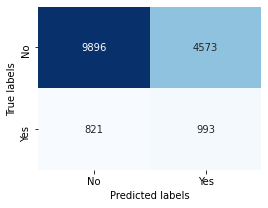

[CV 5/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.012 total time=  56.6s
[CV 2/5] END class_weight=None, max_depth=None, n_estimators=1000;, score=0.006 total time= 4.0min
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=250;, score=0.000 total time=  27.7s
[CV 2/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.000 total time=  54.5s
[CV 5/5] END class_weight=None, max_depth=10, n_estimators=1000;, score=0.000 total time= 1.9min
[CV 3/5] END class_weight=None, max_depth=15, n_estimators=1000;, score=0.000 total time= 2.7min
[CV 4/5] END class_weight=balanced, max_depth=None, n_estimators=500;, score=0.003 total time= 2.0min
[CV 2/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.268 total time=  14.2s
[CV 5/5] END class_weight=balanced, max_depth=5, n_estimators=250;, score=0.281 total time=  13.9s
[CV 3/5] END class_weight=balanced, max_depth=5, n_estimators=500;, score=0.276 total time=  27.6s
[CV 1/5] END class

In [44]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize = (4,3))

ax = plt.subplot()
sns.heatmap(cm, annot = True, 
            fmt = 'g', 
            cmap = 'Blues',
            ax = ax, cbar = False ); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);

## Grid Search for ROC-AUC

In [45]:
%timeit

clf = RandomForestClassifier(random_state = 42)

param_grid = { 'n_estimators' : [250, 500, 1000],
               'max_depth' : [None, 5, 10, 15],
               'class_weight' : [None, 'balanced']
}

grid_search = GridSearchCV(clf, 
                           param_grid,
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'roc_auc',
                           verbose = 5)

grid_search.fit(X_train_tf, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15],
                         'n_estimators': [250, 500, 1000]},
             scoring='roc_auc', verbose=5)

In [46]:
print(grid_search.best_score_, grid_search.best_params_)

y_pred_test = grid_search.predict(pipe.transform(X_test))
y_pred_train = grid_search.predict(X_train_tf)

print(classification_report(y_test, y_pred_test))

print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))
print('F1-Score:', f1_score(y_train, y_pred_train))
print('\n')
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('Recall:', recall_score(y_test, y_pred_test))
print('F1-Score:', f1_score(y_test, y_pred_test))

0.6688832164342958 {'class_weight': None, 'max_depth': 10, 'n_estimators': 1000}
              precision    recall  f1-score   support

       False       0.89      1.00      0.94     14469
        True       0.00      0.00      0.00      1814

    accuracy                           0.89     16283
   macro avg       0.44      0.50      0.47     16283
weighted avg       0.79      0.89      0.84     16283

Accuracy: 0.8885703275529865
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


Accuracy: 0.8885954676656636
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hom

[CV 2/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.654 total time= 1.8min
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.648 total time=  12.9s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.667 total time=  13.1s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.671 total time=  12.9s
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.655 total time=  13.5s
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=250;, score=0.673 total time=  15.7s
[CV 3/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.671 total time=  28.7s
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.648 total time= 1.0min
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.656 total time=  58.3s
[CV 1/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.654 total time= 1.0min
[CV 4/5] END class_weight=None, max_depth=10

[CV 2/5] END class_weight=None, max_depth=None, n_estimators=250;, score=0.652 total time=  56.6s
[CV 4/5] END class_weight=None, max_depth=None, n_estimators=500;, score=0.638 total time= 1.8min
[CV 1/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.648 total time=  30.4s
[CV 4/5] END class_weight=None, max_depth=5, n_estimators=500;, score=0.656 total time=  29.1s
[CV 2/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.668 total time= 1.0min
[CV 5/5] END class_weight=None, max_depth=5, n_estimators=1000;, score=0.673 total time= 1.0min
[CV 5/5] END class_weight=None, max_depth=10, n_estimators=500;, score=0.681 total time= 1.0min
[CV 3/5] END class_weight=None, max_depth=15, n_estimators=250;, score=0.669 total time=  40.9s
[CV 1/5] END class_weight=None, max_depth=15, n_estimators=500;, score=0.654 total time= 1.3min
[CV 4/5] END class_weight=None, max_depth=15, n_estimators=1000;, score=0.660 total time= 2.6min
[CV 5/5] END class_weight=balanced, m

In [15]:
# pd.Series(pipe['clf'].feature_importances_).sort_values(ascending = False)

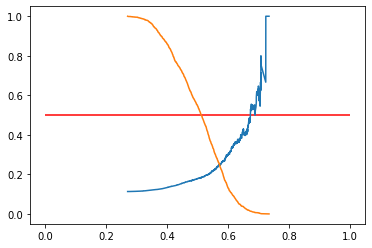

In [115]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)

precision = precision[:-1]
recall = recall[:-1]

plt.plot(thresholds,precision)
plt.plot(thresholds,recall)
plt.hlines(y=0.5,xmin=0, xmax=1, colors='red')
plt.show()

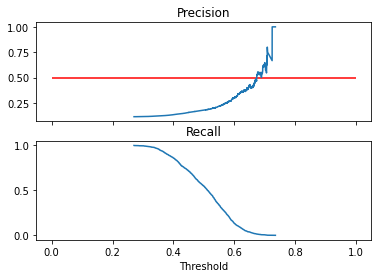

In [116]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

### Discrimination Analysis

In [48]:
def verify_descrimination(X_test, 
                          y_test, 
                          y_pred, 
                          max_diff = 0.10,
                          min_percent = 0.0,
                          sensitive_column = 'gender'):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    sensitive_classes = X_test[sensitive_column].unique()
    
    min_samples = X_test.shape[0]*min_percent
    
    is_satisfied = True
    # precisions = {}
    recalls = {}
    
    for sensitive_class in sensitive_classes:
        mask = X_test[sensitive_column] == sensitive_class
        if mask.sum() > min_samples:
            # precisions[sensitive_class] = precision_score(y_test[mask], y_pred[mask])
            recalls[sensitive_class] = recall_score(y_test[mask], y_pred[mask])

    diff = np.max(list(recalls.values())) - np.min(list(recalls.values()))
    if diff > max_diff:
        is_satisfied = False

    return is_satisfied, diff, recalls

In [49]:
verify_descrimination(X_test, y_test, y_pred_test, sensitive_column = 'gender')

(True,
 0.022558641305214455,
 {'Female': 0.5609264853977844, 'Male': 0.53836784409257})

In [51]:
cr = CorrectRace()
X_test_race = cr.fit_transform(X_test)

verify_descrimination(X_test_race, y_test, y_pred_test, sensitive_column = 'race')

/home/pgomes/projects/capstone_project/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.col] = X[self.col].str.lower().replace(self.map)


(False,
 0.1523809523809524,
 {'caucasian': 0.5475671750181554,
  'black': 0.5619596541786743,
  'latino': 0.6285714285714286,
  'other': 0.47619047619047616,
  'asian': 0.6})

In [52]:
# ca = ConvertAge()
# X_test_age = ca.fit_transform(X_test)

verify_descrimination(X_test, y_test, y_pred_test, sensitive_column = 'age')

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(False,
 0.7555555555555555,
 {'[70-80)': 0.5529661016949152,
  '[30-40)': 0.5606060606060606,
  '[60-70)': 0.5239294710327456,
  '[80-90)': 0.6158536585365854,
  '[50-60)': 0.47346938775510206,
  '[40-50)': 0.5408805031446541,
  '[10-20)': 0.0,
  '[90-100)': 0.5777777777777777,
  '[20-30)': 0.7555555555555555,
  '[0-10)': 0.0})

In [53]:
verify_descrimination(X_test, y_test, y_pred_test, sensitive_column = 'payer_code', min_percent = 1e-2)

(False,
 0.29245947850599013,
 {'SP': 0.5263157894736842,
  'BC': 0.5066666666666667,
  'MC': 0.589171974522293,
  'CP': 0.5142857142857142,
  'HM': 0.5247524752475248,
  'UN': 0.46511627906976744,
  'CM': 0.7575757575757576,
  'OG': 0.6666666666666666,
  'MD': 0.6363636363636364})

In [24]:
verify_descrimination(X_test, y_test, y_pred_test, sensitive_column = 'medical_specialty', min_percent = 1e-2)

(False,
 0.5060975609756098,
 {'InternalMedicine': 0.524390243902439,
  'Family/GeneralPractice': 0.544,
  'Surgery-General': 0.6181818181818182,
  'Cardiology': 0.3466666666666667,
  'Emergency/Trauma': 0.6643356643356644,
  'Radiologist': 0.25,
  'Orthopedics': 0.72,
  'Nephrology': 0.7560975609756098,
  'Orthopedics-Reconstructive': 0.7272727272727273})

In [32]:
def verify_no_discrimination(X_test, 
                             y_true, 
                             y_pred, 
                             sensitive_column='race', 
                             max_diff=0.05,
                             min_percent=0.005):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['medical_specialty'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    min_samples = X_test.shape[0]*min_percent
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    
    for department in departments:
        # precisions = {}
        recalls = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test[sensitive_column] == department)
            if np.sum(mask) > min_samples:
                recalls[sensitive_class] = recall_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(recalls) > 1:    
            diff = np.max(list(recalls.values())) - np.min(list(recalls.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, recalls))
            else:
                good_deparments.append((department, diff, recalls))
        else:
            ignored_departments.append((department, None, []))
    
    # global_precisions = {}
    global_recalls = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_recalls[sensitive_class] = recall_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(recalls) > 1:    
        diff = np.max(list(recalls.values())) - np.min(list(recalls.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_recalls

In [33]:
verify_no_discrimination(X_test_race, y_test, y_pred_test, sensitive_column = 'age', max_diff=0.1)

(True,
 [],
 [],
 {'[70-80)': 0.5529661016949152,
  '[30-40)': 0.5606060606060606,
  '[60-70)': 0.5239294710327456,
  '[80-90)': 0.6158536585365854,
  '[50-60)': 0.47346938775510206,
  '[40-50)': 0.5408805031446541,
  '[10-20)': 0.0,
  '[90-100)': 0.5777777777777777,
  '[20-30)': 0.7555555555555555})

In [31]:
verify_no_discrimination(X_test_race, y_test, y_pred_test, sensitive_column = 'admission_source_code', max_diff=0.1)

(False,
 [('InternalMedicine',
   0.10561403508771927,
   {7: 0.5266666666666666, 1: 0.5185185185185185, 6: 0.42105263157894735}),
  ('Family/GeneralPractice',
   0.17142857142857143,
   {7: 0.6, 1: 0.56, 17: 0.42857142857142855}),
  ('Surgery-General',
   0.2990196078431372,
   {7: 0.9166666666666666, 1: 0.6176470588235294}),
  ('Cardiology',
   0.130952380952381,
   {7: 0.38461538461538464, 1: 0.2857142857142857, 17: 0.4166666666666667}),
  ('Nephrology', 0.4117647058823529, {7: 1.0, 1: 0.5882352941176471})],
 [],
 {7: 0.5942857142857143,
  1: 0.5009746588693957,
  17: 0.4649122807017544,
  4: 0.3793103448275862,
  6: 0.4117647058823529,
  2: 0.4666666666666667,
  5: 0.8421052631578947})